## import

In [2]:
#importing libraries & packages
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style='darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline
import pandas_profiling
import datetime
import re
import pprint
pp = pprint.PrettyPrinter(indent=4)
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

#display multiple outputs from cell 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# # machine learning
# import sklearn
# from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
# from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
# from sklearn.pipeline import Pipeline, make_pipeline
# from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler
# from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, classification_report
# from sklearn.linear_model import LogisticRegression
# from sklearn.utils import resample
# from imblearn.over_sampling import ADASYN, SMOTE
# from sklearn.feature_selection import SelectKBest, chi2
# from sklearn.base import clone 

# #from sklearn.utils import compute_class_weight

In [3]:
# import Animal Control Incidents df
df = pd.read_csv('Animal_Control_Incidents.csv')

## functions

In [4]:
# regex for letters and '/' only, unless pattern reassigned
def remove_numpunc(list, pattern='[^A-Za-z,]+'):
    """regex to apply to list/df column --default: to include only letters and ',' """
    pattern = pattern
    #pattern = '[^A-Za-z_]+'
    if pattern =='[^A-Za-z,]+':
        list = [re.sub(pattern, ',', i) for i in list] 
    if pattern == '[^A-Za-z_]+':
        list = [re.sub(pattern, '', i) for i in list]
    if pattern == '[^A-Za-z/]+':
        list = [re.sub(pattern, '/', i) for i in list]
    if pattern == '[^0-9]+':
        list = [re.sub(pattern, '', i) for i in list]
    return list

In [5]:
# str type, eliminate misplaced whitespace, lower casing, replacing blankspace with '_'
def clean_str(col):
    
    df[col] = df[col].astype(str, skipna=True)
    df[col] = df[col].str.strip()
    df[col] = df[col].apply(lambda x: x.replace(' ', '_'))
    df[col] = df[col].str.lower()

In [6]:
# plotting counts of timedate data 
def plot_dtcount(td_df, col, limitsy = None, limitsx= None, overlap = True, labels = None, alpha=0.3, size=6):
    """Plots incident count(y) with timeframe as x axis:
    
        td_df = dataframe with date/time
        col = date/time column(s) of dataframe to plot counts
        limitsy= (y,y), limitsx= (x,x) can be adjusted
         -, helful if wanting to exclude extreme outliers -
         overlap= boolean(if looping and want plots seperately plotted, set to False)
         labels= str or list of str for legend
         """
    
    td_df[col] = td_df[col].dropna()
    time_c = td_df.groupby([col])[col].count()
    
    if limitsy:
        plt.ylim(limitsy)
        
    if limitsx:
        plt.xlim(limitsx)

    if labels:
        plt.legend(
        (labels),
        loc='upper right'
        ,fontsize= 12)
    
    plt.scatter(time_c.index, time_c.values, s= size, alpha=alpha, label=col)
    if not overlap:
        plt.xlabel(col)
        plt.show();

In [7]:
# pretty blue/green seaborn correlation plot for categorical data
def corr_plot(data, minv=-.3, maxv=.3, dummy=True):
    """pretty blue/green seaborn correlation plot:
    
    data= dataframe(will include all columns)
    minv = -float, maxv = float  --adjust closer to 0 for more contrast, closer to -1/1 for less
    dummy = False if df is all numerical. when True:function will only dummy categorical features
    """
    
    if dummy:
        # dummy categorical features
        col_list = list(data.select_dtypes(include=['object']).columns)

        # create dummies for categorical features
        data = pd.DataFrame(pd.get_dummies(data=data,columns=col_list
                       , prefix=col_list))
    sns.set(style="white")
    corr = data.corr()

    # mask the size of covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(10, 10))

    sns.heatmap(corr, mask=mask
                ,annot=False, cmap="YlGnBu", vmin = minv, vmax=maxv, center=0,
                square=True, linewidths=.5,cbar_kws= {"shrink": .5} );
    
    #prevent the shrink of bottom row
    ax.set_ylim(len(data.columns), 0)

In [8]:
#sns countplot loop - probably unnecessary
def plot_counts(cols):
    for i, col in enumerate(cols):
        plt.figure(i)
        sns.countplot(y=col, data=df);

In [9]:
# replacing strings and substrings FOR COLOR COLUMN ONLY(could be made more universal)
def edit_replace(old_words, replacement_word):
    """simple replacing strings or list in the df.color column since used so frequently in editting"""
    for word in old_words:
        df['color'] = df['color'].apply(lambda x: x.replace(word, replacement_word))

# __Cleaning__

### overview

looking at size, data types, 'na's

In [10]:
df.shape

(73303, 38)

In [11]:
df.head()

,FILE NUMBER,INCIDENT DATE,INCIDENT TIME,DISPATCHED TIME,CALL TAKER,DISPATCHER,DISPATCHED OTHER,DISPATCHED SITUATION,ARRIVAL TIME,AVAILABLE TIME,...,CONDITION,TEMPERMENT,COLLAR,COLLAR COLOR,VACCINATION NUMBER,VACCINATION DATE,PET NAME,DISPOSITION,DISPOSITION DATE,DISPOSITION OFFICER
0,201639027,12/27/2016,15:30,16:06,UNKNOWN,JENNIFER G,0,D,16:17,16:38,...,FAIR,FRIENDLY,NYLON,RED,NaN,NaN,NaN,TRANS CAA,12/27/2016,FRANK S
1,201639044,12/28/2016,10:06,10:07,UNKNOWN,JENNIFER G,0,D,10:15,10:23,...,FAIR,NORMAL,UNKNOWN,UNKNOWN,NaN,NaN,NaN,RETURN TO WILD,12/28/2016,TRAVIS R
2,201639036,12/28/2016,09:03,09:03,UNKNOWN,JENNIFER G,0,D,09:27,09:45,...,EMACIATED,FRIENDLY,LEATHER,PINK,NaN,NaN,NaN,TRANS CAA,12/28/2016,ISAAC S
3,201639042,12/28/2016,09:46,10:24,UNKNOWN,JENNIFER G,0,D,10:35,10:47,...,EMACIATED,FRIENDLY,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TRANS CAA,12/28/2016,JOHN B
4,201639059,12/28/2016,15:05,15:45,UNKNOWN,JENNIFER G,0,D,16:07,16:25,...,EMACIATED,NORMAL,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TRANS CAA,12/28/2016,SUE H


lower casing the column names and replacing whitespace:

In [12]:
# removing spaces and lower casing the column names
df.columns = df.columns.str.lower()
df.columns = df.columns.str.strip()
df.columns = df.columns.str.replace(' ', '_')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73303 entries, 0 to 73302
Data columns (total 38 columns):
file_number             73303 non-null int64
incident_date           73303 non-null object
incident_time           72818 non-null object
dispatched_time         62547 non-null object
call_taker              53134 non-null object
dispatcher              60239 non-null object
dispatched_other        73303 non-null int64
dispatched_situation    62537 non-null object
arrival_time            61843 non-null object
available_time          62545 non-null object
complainant_street      73281 non-null object
request_type            40141 non-null object
officer                 61235 non-null object
equipment_number        60251 non-null object
remarks                 2098 non-null object
impound_number          53110 non-null float64
impound_date            53105 non-null object
impound_time            53046 non-null object
location                52867 non-null object
municipality       

Although most features are classified appropriately, some of these columns would probably be better described as object than int or float. There are also many dates and times to convert to datetime.  A lot of nulls.

Checking for duplicates:

In [14]:
# any duplicate rows?
print (len(df[df.duplicated(keep='first')])/len(df))
df[df.duplicated(keep=False)]

0.003396859610111455


,file_number,incident_date,incident_time,dispatched_time,call_taker,dispatcher,dispatched_other,dispatched_situation,arrival_time,available_time,...,condition,temperment,collar,collar_color,vaccination_number,vaccination_date,pet_name,disposition,disposition_date,disposition_officer
36519,2012224989,01/17/2012,8:16,8:49,BC,BC,0,D,9:11,9:28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRANS CAA,01/17/2012,NaN
36520,2012224989,01/17/2012,8:16,8:49,BC,BC,0,D,9:11,9:28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRANS CAA,01/17/2012,NaN
36738,2012228091,03/16/2012,10:34,13:10,NaN,BC,0,D,13:22,13:30,...,FAIR,NORMAL,NaN,NaN,NaN,NaN,NaN,TRANS CAA,03/16/2012,SW1
36739,2012228091,03/16/2012,10:34,13:10,NaN,BC,0,D,13:22,13:30,...,FAIR,NORMAL,NaN,NaN,NaN,NaN,NaN,TRANS CAA,03/16/2012,SW1
36862,2012231293,05/15/2012,8:32,9:27,NaN,BC,0,D,9:36,9:45,...,FAIR,NORMAL,NaN,NaN,NaN,NaN,NaN,TRANS CAA,05/15/2012,SW1
36863,2012231293,05/15/2012,8:32,9:27,NaN,BC,0,D,9:36,9:45,...,FAIR,NORMAL,NaN,NaN,NaN,NaN,NaN,TRANS CAA,05/15/2012,SW1
36864,2012231293,05/15/2012,8:32,9:27,NaN,BC,0,D,9:36,9:45,...,FAIR,NORMAL,NaN,NaN,NaN,NaN,NaN,TRANS CAA,05/15/2012,SW1
36865,2012231293,05/15/2012,8:32,9:27,NaN,BC,0,D,9:36,9:45,...,FAIR,NORMAL,NaN,NaN,NaN,NaN,NaN,TRANS CAA,05/15/2012,SW1
37062,2012226886,02/22/2012,17:4,NaN,TR,NaN,0,NaN,NaN,NaN,...,FAIR,NORMAL,NaN,NaN,NaN,NaN,NaN,TRANS CAA,02/22/2012,SW1
37063,2012226886,02/22/2012,17:4,NaN,TR,NaN,0,NaN,NaN,NaN,...,FAIR,NORMAL,NaN,NaN,NaN,NaN,NaN,TRANS CAA,02/22/2012,SW1


.05% of rows appear to be duplicates, so I will remove.

In [15]:
#sorting by rows with most nas
df = df.iloc[df.isnull().sum(axis=1).mul(-1).argsort()]


# removing duplicate rows from df - data entry mistakes?
df.drop_duplicates(keep='last', inplace=True)

According to the data source, file numbers should all be unique to each incident. Repeated file numbers could be duplicates of the same incident with benign differences/errors. If there's not an overwhelming amount of entries with duplicate file number, incident date and incident time, I would say it's safe to drop the duplicates.

In [16]:
# duplicate file numbers could also indicate duplicates with minor indiscretions 
print (len(df[df.duplicated(subset=['file_number','incident_date', 'incident_time'], keep=False)])/len(df))
df[df.duplicated(subset=['file_number', 'incident_date', 'incident_time'], keep=False)]

0.19540340022449149


,file_number,incident_date,incident_time,dispatched_time,call_taker,dispatcher,dispatched_other,dispatched_situation,arrival_time,available_time,...,condition,temperment,collar,collar_color,vaccination_number,vaccination_date,pet_name,disposition,disposition_date,disposition_officer
59958,2013251959,04/17/2013,20:0,NaN,TP,NaN,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRANS CAA,04/17/2013,NaN
57842,2013256085,06/20/2013,14:25,NaN,BG,NaN,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRANS CAA,06/20/2013,NaN
56159,2015301479,12/06/2015,15:42,NaN,BG1,NaN,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRANS CAA,12/06/2015,SW1
60198,2014280818,09/21/2014,7:40,NaN,JB,NaN,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRANS CAA,09/21/2014,NaN
36379,2015298728,10/08/2015,8:44,9:32,NaN,NaN,0,D,NaN,9:47,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRANS CAA,10/08/2015,NaN
58672,2012226725,02/09/2012,15:48,NaN,NaN,NaN,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRANS CAA,02/19/2012,NaN
57250,2012230908,05/07/2012,18:2,NaN,NaN,NaN,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRANS CAA,05/07/2012,NaN
41672,2014285247,12/20/2014,16:40,NaN,TR,NaN,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRANS CAA,12/20/2014,SW1
59167,2013248090,02/10/2013,11:15,NaN,JB,NaN,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRANS CAA,02/10/2013,NaN
54261,2014281408,10/01/2014,21:16,NaN,JTG,NaN,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRANS CAA,10/01/2014,SW1


In [17]:
# # this should drop duplicate file number rows, keeping the row with the lease nas
df = df.loc[df.notnull().sum(1).groupby(df.file_number).idxmax()]
df.drop_duplicates(subset=['file_number'], keep='last', inplace=True)

How much nas per column are there?

In [18]:
#percent missing values per column
round(df.isna().sum()/len(df)*100)

file_number              0.0
incident_date            0.0
incident_time            1.0
dispatched_time         13.0
call_taker              28.0
dispatcher              16.0
dispatched_other         0.0
dispatched_situation    13.0
arrival_time            14.0
available_time          13.0
complainant_street       0.0
request_type            43.0
officer                 17.0
equipment_number        16.0
remarks                 98.0
impound_number          32.0
impound_date            32.0
impound_time            32.0
location                32.0
municipality            32.0
zip_code                69.0
service_code            32.0
species                 32.0
breed                   33.0
sex                     48.0
size                    33.0
color                   33.0
age                     57.0
condition               35.0
temperment              34.0
collar                  68.0
collar_color            68.0
vaccination_number      99.0
vaccination_date        99.0
pet_name      

Since most features are missing substantial amounts of data, I want to be careful about dropping nas to avoid tossing out useful information with the nulls.

Vaccination number, vaccination date, remarks, and pet name are all missing 98-99% data.  Collar color and collar might be interesting to look at if focus was on something dog related that it may have some relevance to, but I'm wanting to keep a more inclusive approach, and don't see the purpose of collar information. Since other species are included in the data, the collars are probably only seen on cats and dogs for the most part.



In [19]:
# removing columns with 90%+ missing:
df.drop(columns=['remarks', 'vaccination_number', 'vaccination_date', 'collar', 'collar_color', 'pet_name'
                ,'file_number']
        , inplace=True)

In [20]:
#removing row with nas from incident time since such little nas(1% rows)
df = df[df['incident_time'].notna()]

In [21]:
df3= df.copy()

### unimportant

I'll start by investigating the features I feel are not going to be useful, or might have too many nas.

#### age, sex

these features are both missing roughly 50%

In [22]:
df.age.value_counts()/df.age.value_counts().sum()

0.0     0.995040
2.0     0.000992
3.0     0.000735
5.0     0.000735
4.0     0.000441
1.0     0.000367
6.0     0.000257
7.0     0.000220
9.0     0.000220
8.0     0.000220
10.0    0.000184
13.0    0.000147
12.0    0.000110
11.0    0.000073
14.0    0.000073
16.0    0.000073
15.0    0.000073
17.0    0.000037
Name: age, dtype: float64

Not sure about 99% of the animals being 0 years old, it could be a default in data entry. I will be excluding this column. 

In [23]:
df.drop(columns=['age'], inplace=True)

In [24]:
df.sex.value_counts()/df.sex.value_counts().sum()

M    0.351869
U    0.351206
F    0.296685
D    0.000060
1    0.000060
K    0.000030
S    0.000030
N    0.000030
0    0.000030
Name: sex, dtype: float64

In [25]:
for x in ('l','D', 'K', '0', 'N', 'S', '1'):
    df['sex'] = df['sex'].replace(x, np.NaN)

The sexes appear mostly balanced between Male, Female, and Unidentified. I'm not sure what the other letters represent. I probably won't be using this feature.

In [26]:
# df.drop(columns=['sex'], inplace=True)

#### names

In [27]:
name_cols = ['call_taker', 'dispatcher', 'officer', 'disposition_officer'] 

In [28]:
# cleaning name cols
for col in name_cols:
    clean_str(col)
    df[col] = remove_numpunc(df[col], pattern='[^A-Za-z_]+')        

In [29]:
for col in name_cols:
    df[col].value_counts()

unknown       28129
nan           17415
jennifer_g     5920
bc             2411
john_b         1076
bg              884
tr              830
is              758
daniel_p        660
jc              649
tz              558
jb              532
jtg             488
sb              452
jg              408
tp              401
sedwin_b        373
rt              360
fs              198
law             188
ms              160
wb              129
richard_b       103
ac               81
rosemary_a       54
lw               49
sr               43
dp               36
sh               33
joey_g           30
ic               29
sw               14
jpb              13
jason_c           8
                  8
sue_h             7
isaac_s           6
travis_r          5
frank_s           4
jeg               4
mg                3
jw                3
anna_c            3
bjg               2
tf                2
rb                1
je                1
llaw              1
aa                1
tzz               1


jennifer_g    33323
bc            17200
nan            9800
unknown         859
john_b          745
richard_b       722
sedwin_b        600
jtg             138
joey_g          131
bg                5
is                4
rt                2
isaac_s           1
tp                1
passpp            1
                  1
Name: dispatcher, dtype: int64

nan           10674
unknown        9012
frank_s        4167
anna_c         3774
travis_r       3249
jason_c        2994
tr             2943
john_b         2766
jb             2609
bg             2544
sue_h          2415
isaac_s        2116
sb             1764
sedwin_b       1737
lw             1219
is              818
fs              778
jc              675
jtg             656
tz              604
allison_c       599
dd              576
jennifer_g      494
tp              453
mg              451
jg              434
rt              401
jw              337
kd              311
joey_g          295
              ...  
sh               33
hilton_c         31
sw               17
jpb              13
brent_g          11
                  5
bc                5
hc                5
jeg               4
susan_w           4
suzie_b           3
kjg               2
bjg               2
btg               2
kjc               1
rg                1
rb                1
djp               1
fr                1


nan           20739
sw            15508
sb             4469
ph             2763
frank_s        2105
anna_c         2062
jl             1999
travis_r       1678
john_b         1497
jason_c        1404
allison_c      1243
lw             1208
sue_h          1136
sedwin_b       1044
isaac_s        1031
jtg             809
dd              680
kd              419
djp             262
jw              204
joey_g          134
tim_z           130
bg              100
tr               97
jg               87
tp               82
rt               80
is               79
jb               65
susan_w          55
              ...  
ms               40
kw               35
patty_h          28
suzie_b          12
hilton_c          8
ic                7
rosemary_a        5
law               5
jennifer_g        3
bmg               2
dp                2
jrl               2
richard_b         2
swi               2
ab                2
pg                1
je                1
pl                1
bjg               1


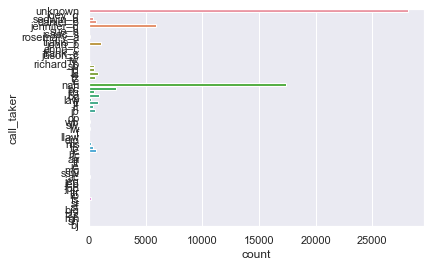

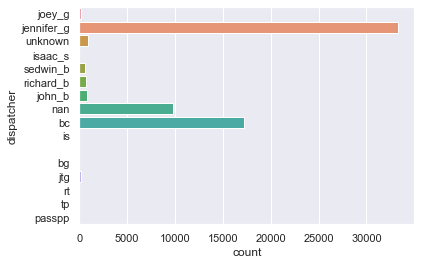

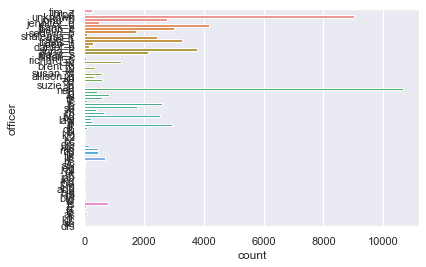

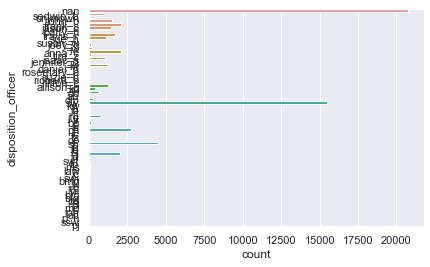

In [30]:
plot_counts(name_cols)



If I was able to consult someone of knowledge at the baton rouge animal control facility, I would be able to sort out the names better(i.e. are any of the initials representative of the given full names). I looked at the staff directory on their website but only found two names listed, and aren't present in the dataset. It was for the director and 'cat in tree complaints'.

This information doesn't seem important enough to include, and is also a little messy for me to navigate without having more information on the staffing of the animal control officers and call takers.

In [31]:
# df.drop(columns = name_cols, inplace=True)

#### equipment number

ID of the vehicle sent to the incident location

In [32]:
df.equipment_number.value_counts()

AC04     5555
AC12     5380
AC09     5378
AC13     4850
AC10     4409
AC06     4270
AC11     4198
AC19     4039
AC18     3386
AC01     3249
AC16     3124
AC15     2493
AC14     1466
AC20      186
19        115
12        100
AC9        77
15         77
4          73
AC6        71
11         62
10         59
13         58
14         55
09         50
AC4        49
9          41
1          37
AC05       37
16         36
         ... 
06         14
AC 19      13
04         11
AC 9       10
AC 4        9
AC 1        7
AC08        7
AC 8        6
AC 18       6
AC 6        5
AC 13       5
18          4
AC 14       4
AC 20       3
5           3
17          3
AC 12       3
AC5         2
AC-14       2
AC-4        1
ZAC14       1
AC 7        1
AC016       1
AC-10       1
AC 15       1
AC- 4       1
SC          1
2692        1
AC198       1
4C18        1
Name: equipment_number, Length: 67, dtype: int64

removing all non digit characters, and removing the beginning 0

In [33]:
# removing characters, and 0s in front of values
clean_str('equipment_number')

df['equipment_number'] = remove_numpunc(df['equipment_number'], pattern ='[^0-9]+')

df['equipment_number'] = df['equipment_number'].apply(lambda x : x[1:] if x.startswith("0") else x)

replacing the out of bounds numbers with Nan, replacing the '4C18' value, which I have assumed was intended to be AC18. Also, replacing the values that had no digits with NaN.

In [34]:
# replacing odd values wih nans, or other assumed value
df['equipment_number'] = df.equipment_number.replace('2692', 'nan')
df['equipment_number'] = df.equipment_number.replace('198', 'nan')
df['equipment_number'] = df.equipment_number.replace('418', '18')
df['equipment_number'] = df['equipment_number'].apply(lambda x : x.replace(x,'nan') if x=='' else x)

df.loc[df['equipment_number'] == 'nan', 'equipment_number'] = np.NaN

In [35]:
df.equipment_number.value_counts()

4     5699
9     5556
12    5483
13    4913
10    4484
6     4393
11    4282
19    4167
18    3397
1     3344
16    3161
15    2571
14    1528
20     189
5       42
7       35
17      28
8       13
Name: equipment_number, dtype: int64

#### impound_number

Number used to track animals being impounded into shelter.

In [36]:
df.impound_number.value_counts()

0.0        20
46757.0     2
36155.0     2
24181.0     2
42765.0     2
20866.0     2
24164.0     2
64540.0     2
58487.0     2
26043.0     2
24941.0     2
27535.0     2
41801.0     2
61184.0     2
52488.0     2
24290.0     2
30292.0     2
26970.0     2
27288.0     2
35637.0     2
24267.0     2
59758.0     2
29797.0     2
40689.0     2
20057.0     2
23447.0     2
38486.0     2
53254.0     2
63752.0     2
38399.0     2
           ..
79168.0     1
88590.0     1
81436.0     1
51477.0     1
22195.0     1
47900.0     1
79167.0     1
45034.0     1
79170.0     1
43841.0     1
91070.0     1
59834.0     1
94533.0     1
85466.0     1
57858.0     1
79713.0     1
79173.0     1
35835.0     1
59778.0     1
57993.0     1
76064.0     1
79172.0     1
76071.0     1
42459.0     1
79043.0     1
42190.0     1
90065.0     1
79171.0     1
79071.0     1
90112.0     1
Name: impound_number, Length: 43268, dtype: int64

0.0 values are being reassigned to NaN

In [37]:
# what do the 0 impound number rows look like
df[ df['impound_number'] == 0.0 ]

,incident_date,incident_time,dispatched_time,call_taker,dispatcher,dispatched_other,dispatched_situation,arrival_time,available_time,complainant_street,...,species,breed,sex,size,color,condition,temperment,disposition,disposition_date,disposition_officer
63860,05/03/2012,8:19,9:4,nan,bc,0,D,9:28,9:43,ELLIOT RD,...,WILDLIFE,OTHER,NaN,MEDIUM,RED,NaN,NaN,RETURN TO WILD,05/04/2012,jl
64630,07/17/2012,9:7,9:11,nan,bc,0,D,9:36,9:37,FRONTIER DR,...,WILDLIFE,SQUIRREL,NaN,SMALL,NaN,FAIR,NERVOUS,RETURN TO WILD,07/17/2012,jl
58310,08/14/2012,9:55,NaN,jg,nan,0,NaN,NaN,NaN,GIBBENS,...,CAT,DSH,NaN,SMALL,GRY/BLK/BRWN,FAIR,NORMAL,TRANS CAA,08/15/2012,sw
53784,10/07/2012,13:41,NaN,tr,nan,1,NaN,NaN,NaN,SKYSKAIL,...,DOG,XDACHSHUND,NaN,MEDIUM,BRIN BLK WHT,FAIR,NERVOUS,TRANS CAA,10/08/2012,nan
49239,12/28/2012,8:27,9:10,nan,bc,0,D,9:19,9:28,HAVENWOOD DR,...,WILDLIFE,POSSUM,NaN,MEDIUM,WHT/GRY,FAIR,NORMAL,RETURN TO WILD,12/28/2012,jl
35998,02/19/2013,9:56,10:21,nan,nan,0,D,10:34,10:44,SHERWOOD FOREST DR,...,CAT,DSH,NaN,LARGE,BLK/WHT,FAIR,NERVOUS,TRANS CAA,02/19/2013,sw
49179,05/01/2013,12:33,13:22,nan,bc,0,D,13:31,13:46,MADISON AV,...,WILDLIFE,POSSUM,U,MEDIUM,GREY,FAIR,NORMAL,RETURN TO WILD,05/01/2013,jl
38545,07/09/2013,8:36,8:54,bc,bc,0,D,9:18,9:47,CRESTVIEW AV,...,DOG,ROTTWEILLER,NaN,MEDIUM,BLK/TAN,FAIR,NORMAL,TRANS CAA,07/10/2013,sb
53032,08/01/2013,9:47,10:16,nan,bc,0,D,10:36,10:44,OAKMOUNT DR,...,WILDLIFE,RACCOON,NaN,LARGE,BRN/BLK,FAIR,NORMAL,RETURN TO WILD,08/01/2013,jl
69585,11/24/2013,18:6,NaN,rt,nan,0,NaN,NaN,NaN,CHERRY BARK,...,WILDLIFE,POSSUM,U,EXTRA LARGE,GREY,FAIR,NORMAL,RETURN TO WILD,11/24/2013,sb


Although many of these were transferred to the animal shelter, the record fails to show unique impound numbers for them.

In [38]:
# replacing '0.0' impound with NaT
df.loc[df['impound_number'] == 0.0, 'impound_number'] = np.NaN

In [39]:
#print (len(df[df.duplicated(subset=['file_number','incident_date'], keep=False)])/len(df))
df[df.duplicated(subset=['impound_number'], keep=False)]

,incident_date,incident_time,dispatched_time,call_taker,dispatcher,dispatched_other,dispatched_situation,arrival_time,available_time,complainant_street,...,species,breed,sex,size,color,condition,temperment,disposition,disposition_date,disposition_officer
28371,05/02/2016,06:03,08:52,unknown,joey_g,0,D,09:07,09:17,AVENUE C ST,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
28329,05/02/2016,06:04,09:18,unknown,joey_g,0,D,09:33,09:51,TRUMAN ST,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
28277,05/02/2016,06:06,08:26,unknown,joey_g,0,D,08:45,08:53,CHARLES ST,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
3060,05/02/2016,06:15,00:00,unknown,joey_g,0,K,00:00,00:00,HUNTERS TRAIL DR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
28255,05/02/2016,06:18,09:51,unknown,joey_g,0,D,10:09,10:11,SAUL AV,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
2196,05/02/2016,06:19,13:38,unknown,joey_g,0,D,14:34,14:34,WILLIAMS RD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
28251,05/02/2016,06:23,08:27,unknown,joey_g,0,D,08:47,08:51,PLAZA DR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
3050,05/02/2016,06:23,10:14,unknown,joey_g,0,D,10:14,10:33,O'NEAL LN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
3168,05/02/2016,06:24,08:39,unknown,joey_g,0,D,08:45,08:48,PLANK RD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
891,05/02/2016,07:28,08:28,unknown,joey_g,0,D,08:58,09:10,ORLANDO DR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan


I don't notice any rows that look similar enough to be considered duplicates. However, I don't see this feature being useful for me.

In [40]:
# df.drop(columns=['impound_number'], inplace=True)

#### dispatched situation, dispatched other

- __dispatched situation:__ Indicates if officer was dispatched (D) or the call had to be postponed (K) and addressed the following day. ( _data source does not explain U,F, or N_ )


- __dispatched_other:__ Not dispatched by cad but there is dispatch info in record



In [41]:
for col in ('dispatched_situation', 'dispatched_other'):
    df[col].value_counts()

D    51144
K     4566
U      155
F        5
N        1
Name: dispatched_situation, dtype: int64

0    62337
1     1196
Name: dispatched_other, dtype: int64

In [42]:
# replacing unknowns with na
for word in ('U','F', 'N'):
    df['dispatched_situation'] = df['dispatched_situation'].replace(word, np.NaN)

I probably won't be using these features in the model, but the dispatched situation is something I might come back to in future wrk

In [43]:
# # won't be needing these
# df.drop(columns=['dispatched_situation', 'dispatched_other'], inplace=True)

### service code, request type (service_type)

Request type is the type of incident being reported, and similarly, service code is used at the responding officer's discretion. There may be some differences, but hoping they're similar enough to merge into one feature to avoid covariance. 

In [44]:
sr = ('service_code', 'request_type')

In [45]:
for col in sr:
    print('--',col.capitalize(),'--\n',df[col].value_counts(),'\n')

-- Service_code --
 TRAPPED ANIMAL           16254
STRAY                     6694
STRAY AN. SECURED         3703
STRAY AN SECURED          2186
LOOSE                     2078
INJURED                   1934
OWNER SIGNED RELEASE      1441
ABANDONED ANIMAL          1235
WILD LIVE                 1222
BITE CASE LOOSE            842
SICK ANIMAL                779
UNIT STANDING BY           772
ANIMAL RESCUE              727
CRUELTY                    600
VET PICKUP                 510
BITE CASE SECURE           427
DANGEROUS ANIMAL SIT.      354
SNAKE                      335
DANGEROUS ANIMAL SIT       279
SCHOOL CALL                242
LOOSE LIVESTOCK            242
UNKNOWN                    228
SPECIAL CASE               132
BITE CASE                  106
DOG FIGHTING                13
OWNED                        4
HIT BY CAR                   1
Name: service_code, dtype: int64 

-- Request_type --
 UNKNOWN                       6405
TRAPPED ANIMAL                5737
STRAY             

In [46]:
#fixing service codes

def rename_code(word, new):
    df.loc[df['service_code'] == word, 'service_code'] = new

#stray
rename_code('STRAY AN. SECURED', 'STRAY')
rename_code('STRAY AN SECURED', 'STRAY')
#dangerous
rename_code('DANGEROUS ANIMAL SIT', 'DANGEROUS')
rename_code('DANGEROUS ANIMAL SIT.', 'DANGEROUS')
#bite
rename_code('BITE CASE LOOSE', 'BITE CASE')
rename_code('BITE CASE SECURE', 'BITE CASE')
#wildlife
rename_code('WILD LIVE', 'WILD LIFE')
#others
rename_code('UNKNOWN', np.NaN)
rename_code('OTHER', np.NaN)
#abandoned
rename_code('ABANDONED ANIMAL', 'ABANDONED')

In [47]:
# fixing request types

def rename_type(word, new):
    df.loc[df['request_type'] == word, 'request_type'] = new
#stray    
rename_type('STRAY ANIMAL SECURED', 'STRAY')
rename_type('STRAY ANIMAL', 'STRAY')
#dangerous
rename_type('DANGEROUS ANIMAL SITUATION', 'DANGEROUS')
#school
rename_type('ANIMAL ON SCHOOL CAMPUS', 'SCHOOL CALL')
#others
rename_type('UNKNOWN', np.NaN)
rename_type('OTHER', np.NaN)
#abandoned
rename_type('ABANDONED DOG', 'ABANDONED')

rename_type('CRUELTY RECHECK', 'RECHECK')

In [48]:
# cleaning up service code and request type
for col in ('service_code', 'request_type'):
    clean_str(col)
    df[col] = remove_numpunc(df[col], pattern='[^A-Za-z_]+')
    df.loc[df[col] == 'nan', col] = np.NaN

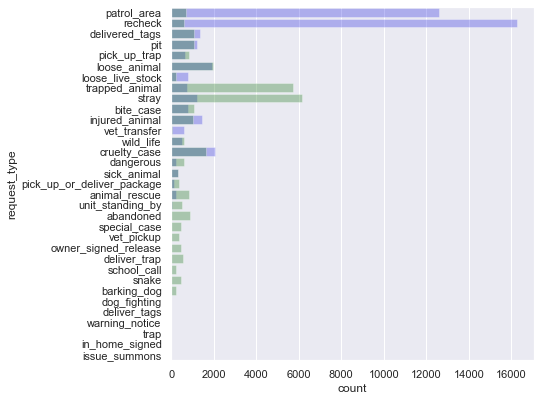

In [49]:
# common values of service code and request type
f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.countplot(y='service_code', data=df, color='blue', alpha=.3)
sns.countplot(y='request_type', data=df, color='green', alpha=.3);

In [50]:
# re-categorizing similar service types

for word in ('dog_fighting', 'dangerous', 'bite_case'):
    df['service_code'] = df['service_code'].replace(word, 'bite_dangerous')
    df['request_type'] = df['request_type'].replace(word, 'bite_dangerous')
    
for word in ('issue_summons', 'in_home_signed', 'warning_notice', 'special_case', 'deliver_tags', 'trap'):
    df['service_code'] = df['service_code'].replace(word, 'other')
    df['request_type'] = df['request_type'].replace(word, 'other')
    
for word in ('loose_animal', 'loose_livestock', 'wild_life', 'stray', 'loose', 'loose_live_stock'):
    df['service_code'] = df['service_code'].replace(word, 'loose_stray')
    df['request_type'] = df['request_type'].replace(word, 'loose_stray')
    
for word in ('injured_animal', 'vet_transfer', 'sick_animal', 'injured', 'vet_pickup', 'hit_by_car'):
    df['service_code'] = df['service_code'].replace(word, 'sick_inj')
    df['request_type'] = df['request_type'].replace(word, 'sick_inj')

for word in ('cruelty', 'cruelty_case', 'abandoned', 'animal_rescue'):
    df['service_code'] = df['service_code'].replace(word, 'cruelty')
    df['request_type'] = df['request_type'].replace(word, 'cruelty')
    
for word in ('owned', 'owner_signed_release'):
    df['service_code'] = df['service_code'].replace(word, 'owned')
    df['request_type'] = df['request_type'].replace(word, 'owned')
    
for word in ('patrol_area', 'recheck', 'unit_standing_by'):
    df['service_code'] = df['service_code'].replace(word, 'patrol')
    df['request_type'] = df['request_type'].replace(word, 'patrol')

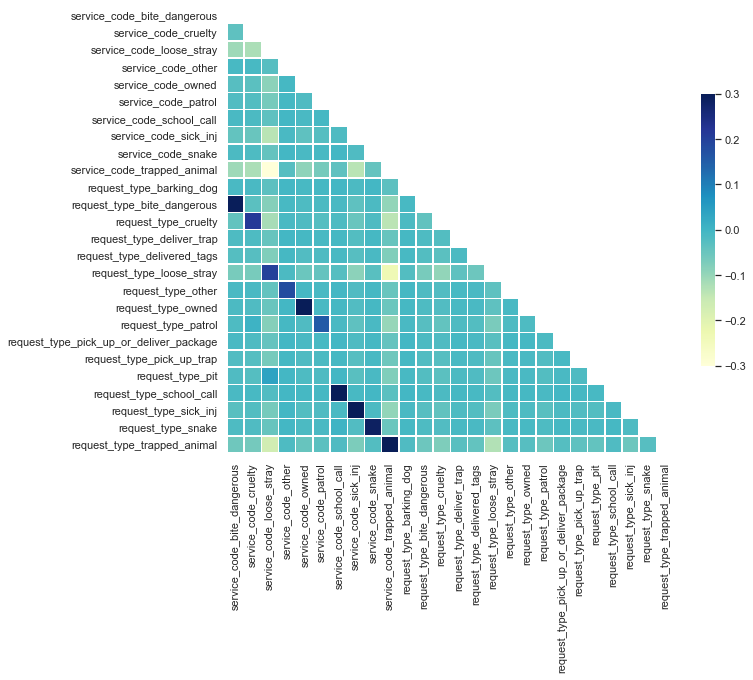

In [51]:
sr_df = df[['service_code', 'request_type']]
corr_plot(sr_df)

In [52]:
# creating column that fills in missing values from service code using existing values from request type
df['service_type']=df['service_code'].mask(pd.isnull, df['request_type'])

# dropping merged columns
df.drop(columns=['service_code', 'request_type'], inplace=True)

In [53]:
# removing punctuations, lower casing, etc..
clean_str('service_type')
df['service_type'] = remove_numpunc(df['service_type'], pattern='[^A-Za-z_]+')

In [54]:
# def rep_service(word, replacement):
#     df['service_type'] = df['service_type'].apply(lambda x: x.replace(word, replacement))  

# # unifying service types

# #cruelty case
# rep_service('abandoned', 'cruelty_case')
# rep_service('cruelty_case', 'cruelty')

# # stray animals
# rep_service('stray_animal_secured', 'stray_an_secured')

# #loose animal and loose could include loose livestock, so I will assign all to 'loose'
# rep_service('loose_animal', 'loose')
# rep_service('loose_livestock', 'loose')
# #rep_service('loose_animal', 'loose')

# # injured - injured animal and injured dog all under injured
# rep_service('pick_up_trap', 'trap')
# rep_service('deliver_trap', 'trap')
# rep_service('hit_by_car', 'injured')

# #
# rep_service('delivered_tags', 'deliver_tags')

# rep_service('wild_live', 'wild_life')

# rep_service('other', 'unknown')

# rep_service('abandoned_dog', 'abandoned_animal')
# rep_service('abandoned_animal', 'abandoned')

# rep_service('animal_on_school_campus', 'school_call')

# rep_service('owned', 'owner_signed_release')

In [55]:
df.service_type.value_counts()

loose_stray                   20649
trapped_animal                16713
nan                            5708
cruelty                        4945
sick_inj                       3798
bite_dangerous                 3013
patrol                         2146
owned                          1532
delivered_tags                 1065
pick_up_trap                    786
snake                           674
pit                             626
other                           514
deliver_trap                    479
pick_up_or_deliver_package      350
school_call                     334
barking_dog                     201
Name: service_type, dtype: int64

In [4]:
# import Animal Control Incidents df
df = pd.read_csv('a_control.csv')

### date & time

Converting dates and times to appropriate format.


#### datetime: incident and impound

- Merging incident date and time to datetime column, repeat with impound date & time.

In [56]:
# incident date + incident time for merged datetime column
df['inc_dt'] = pd.to_datetime(df['incident_date'].apply(str)+' '+df['incident_time'])

# impound date + impound time = impound datetime
df['imp_dt'] = pd.to_datetime(df['impound_date'].apply(str)+' '+df['impound_time'], errors ='coerce')

In [57]:
#assigning NaT to out of bounds dates and times
for col in ('inc_dt', 'imp_dt'):   
    df.loc[df[col] == datetime.time(0, 0, 0), col] = pd.NaT
    df.loc[df[col] < '2012-01-01 00:00:00 ', col] = pd.NaT

df = df.sort_values(by='inc_dt')
df.reset_index(drop=True, inplace=True)

In [58]:
df.head()

,incident_date,incident_time,dispatched_time,call_taker,dispatcher,dispatched_other,dispatched_situation,arrival_time,available_time,complainant_street,...,size,color,condition,temperment,disposition,disposition_date,disposition_officer,service_type,inc_dt,imp_dt
0,01/01/2012,11:20,NaN,jg,nan,0,NaN,NaN,NaN,CHEVELLE,...,LARGE,YELLOW/RED,FAIR,FRIENDLY,TRANS CAA,01/01/2012,sw,loose_stray,2012-01-01 11:20:00,2012-01-01 11:20:00
1,01/01/2012,14:12,NaN,is,nan,0,NaN,NaN,NaN,SHERWOOD,...,SMALL,GRY/WHT,FAIR,NORMAL,TRANS CAA,01/01/2012,sw,bite_dangerous,2012-01-01 14:12:00,2012-01-01 14:12:00
2,01/01/2012,15:4,NaN,is,nan,0,NaN,NaN,NaN,RICHMOND,...,LARGE,WHT/BRINDLE,FAIR,DANGEROUS,TRANS CAA,01/01/2012,sw,bite_dangerous,2012-01-01 15:04:00,2012-01-01 15:04:00
3,01/01/2012,16:51,NaN,jb,nan,0,NaN,NaN,NaN,STEARNS,...,MEDIUM,GOLD/BLK,GOOD,FRIENDLY,TRANS CAA,01/14/2012,sw,trapped_animal,2012-01-01 16:51:00,2012-01-14 16:51:00
4,01/02/2012,8:34,NaN,jg,nan,0,NaN,NaN,NaN,SUNSET,...,MEDIUM,BLACK,FAIR,NERVOUS,TRANS CAA,01/02/2012,sw,trapped_animal,2012-01-02 08:34:00,2012-01-02 08:34:00


####  Time Features:

In [59]:
# time columns to list, then loop conversion to date.time
time_cols= [col for col in df.columns if 'time' in col]

# covert time to hour/minute datetime format
for col in time_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce', format="%H:%M").dt.time

In [60]:
for col in time_cols:
    df[col].value_counts().head(10)

08:10:00    521
08:08:00    519
08:11:00    518
08:09:00    516
08:12:00    480
08:13:00    441
08:07:00    433
08:14:00    424
08:15:00    393
08:16:00    366
Name: incident_time, dtype: int64

00:00:00    4630
09:16:00     263
09:22:00     258
09:17:00     252
09:20:00     248
09:21:00     245
09:19:00     242
09:15:00     237
09:23:00     236
09:11:00     235
Name: dispatched_time, dtype: int64

00:00:00    5642
09:21:00     259
09:22:00     251
09:23:00     244
09:19:00     242
09:20:00     240
09:13:00     238
09:25:00     238
09:24:00     237
09:16:00     237
Name: arrival_time, dtype: int64

00:00:00    4638
09:16:00     269
09:23:00     263
09:13:00     262
09:14:00     258
09:25:00     255
09:21:00     252
09:22:00     251
09:20:00     246
09:19:00     243
Name: available_time, dtype: int64

09:00:00    264
10:00:00    251
09:30:00    237
09:15:00    219
09:20:00    211
10:30:00    210
09:10:00    196
14:00:00    176
08:50:00    174
10:50:00    173
Name: impound_time, dtype: int64

there's consistently high counts around 8-10ish, although impound times highest look a little more 
The 00:00:00 is probably the default, not actual times, so I will replace with NaT.

In [61]:
# replacing '00:00:00' with NaT
for col in time_cols:
    df.loc[df[col] == datetime.time(0, 0, 0), col] = pd.NaT

In [62]:
print('Incident time Range:\n''from',df.incident_time.min(),'\n to:', df.incident_time.max())

Incident time Range:
from 00:04:00 
 to: 23:58:00


####  Date Features:

In [63]:
# all date columns to list
date_cols= [col for col in df.columns if 'date' in col]

In [64]:
# covert to month/day/year datetime format
for col in date_cols:
    df[col] = pd.to_datetime(df[col],errors='coerce', format="%m/%d/%Y")

In [65]:
for col in date_cols:
    df[col].value_counts().head()
    df[col].value_counts().tail()

2017-07-17    114
2016-11-14    114
2017-05-30    110
2016-05-31    107
2018-01-16    104
Name: incident_date, dtype: int64

2019-03-24    1
2015-06-20    1
2012-01-21    1
2013-12-25    1
2016-06-25    1
Name: incident_date, dtype: int64

2013-10-17    49
2013-12-02    43
2014-06-23    42
2013-10-14    41
2013-06-10    41
Name: impound_date, dtype: int64

2019-06-01    1
2018-11-22    1
2018-11-03    1
2018-11-25    1
2017-03-05    1
Name: impound_date, dtype: int64

2013-10-17    45
2013-12-02    43
2014-06-23    42
2013-10-14    42
2013-06-10    41
Name: disposition_date, dtype: int64

2011-05-07    1
2017-09-13    1
2018-10-01    1
2016-12-03    1
2017-05-09    1
Name: disposition_date, dtype: int64

In [66]:
# date range of dataset
print('Incident Date Range:\n''from:',df.incident_date.min(),'\n to:', df.incident_date.max())

Incident Date Range:
from: 2012-01-01 00:00:00 
 to: 2019-10-03 00:00:00


I noticed some dates were entered as older than 2012,or newer than 2019 which I assume was a mistake. 

In [67]:
#dates out of range to NaT
for col in date_cols:
    df.loc[df[col] < '2012-01-01 00:00:00 ', col] = pd.NaT

#df.loc[df['impound_date'] < '2012-01-01 00:00:00 ']

In [68]:
for col in date_cols:
    df.loc[df[col] > '2019-10-04 00:00:00 ', col] = pd.NaT

#### additional time features:

___
Below, I will be:


- Creating feature representing time difference between incident time and impound time.  

*_The incident date&time is when the incident was called in, the impound time is when the animal was brought to the shelter. It's possible that not every incident called in resulted in an impound, which may be the reason values are missing from impound._


__difference between datetime of incident call and impound datetime__

In [69]:
## time difference from incident to impound- *nevermind- something not right here
## lots of negative times were returned
#df['inc_to_imp'] = df['imp_dt']-df['inc_dt']

In [70]:
# dealing with extreme time values and 0s
for col in ('inc_dt', 'imp_dt'):   
    df.loc[df[col] == datetime.time(0, 0, 0), col] = pd.NaT
    df.loc[df[col] < '2012-01-01 00:00:00 ', col] = pd.NaT

___
Weekday and Month:

This may not provide anything insightful, but I'm creating columns for weekday and month of incident.

__- Weekday Feature-__

In [71]:
# creating day of week column:
df['weekday'] = pd.to_datetime(df['impound_date']).apply(lambda x: x.weekday())

df.weekday.value_counts()
# 0= monday

0.0    8332
2.0    7873
1.0    7855
3.0    7726
4.0    7223
5.0    2416
6.0    1900
Name: weekday, dtype: int64

It looks like most incidents occur on Mondays, and then dwindle down throughout the week, with much less incidents reported on weekends

Are the amount of impounds per day relative to the amount of incidents?

In [72]:
# how does incident day of week compare to impound day of week?:
imp_weekday_counts=(pd.to_datetime(df['incident_date'].dropna()).apply(lambda x: x.weekday()).value_counts())
(imp_weekday_counts.sum())/(df.weekday.value_counts().sum())
imp_weekday_counts/df.weekday.value_counts()
# 0= monday

1.4664281592613964

0    1.689030
1    1.564227
2    1.504382
3    1.489386
4    1.457566
5    0.761175
6    0.765789
dtype: float64

Something seems strange here. The dataframe has 76% of total not-null impounds to total incidents, why would there be 30% more impounds than incidents on any of the days, especially weekends?

___
__- Month feature-__

In [73]:
# column for month
df['month'] = pd.DatetimeIndex(df['impound_date']).month

df.month.value_counts()

6.0     4161
7.0     4137
8.0     4096
5.0     4056
9.0     3966
10.0    3958
4.0     3629
3.0     3586
2.0     3091
1.0     3057
11.0    2966
12.0    2622
Name: month, dtype: int64

__Warmer Climate = More Animal Control Incidents__ 

Not a huge surprise, but May-September appear to have the most incidents. According to weather.com, the average temperature increases rises from the 50's to 60's degree Fahrenheit around min April, and then begins to dip below the 60s again towards the end of October(although Baton Rouge typically experiences the most volume in rainfall in June and August). This isn't a real shocker, just an observation confirming what one might already assume.

*_Note that since the dates run between Jan-1-2012 to Oct-3rd-2019, there will be bias towards the first 10 months._

### animal features

Animals features include __color__, __breed__, __condition__, __temperment__, and __size__. color and breed present an issue with such high unique values for what should be considered , multiple spellings for the same color/breed, and alternate sequences of the same substrings appearing as different values( i.e. brown/white vs white/brown)

#### color

##### unifying spellings of colors

In [74]:
#df.color.value_counts()
df.color.value_counts()

BLK/WHT               3132
BLK                   3101
GRY                   2901
BRWN/WHT              1279
GRY/WHT               1257
TAN/WHT               1156
BRWN                  1136
TAN                   1133
BLK/TAN               1033
GRAY                  1006
BROWN                  930
GREY                   905
GRY/BLK                793
WHT                    700
BLK/GRY                684
BLK/BRWN               635
BRWN/BLK               634
BLACK                  606
BRN/BLK                602
WHT/BLK                588
ORG                    528
WHT/BRWN               519
BRINDLE                484
BRN                    450
TAN/BLK                420
WHT/TAN                410
NORMAL                 373
WHT/GRY                330
WHITE                  323
YELLOW                 303
                      ... 
1 TORT/I 2 BLACK         1
TIGER BLK TAN            1
GREY/BLK/TAN/WHT         1
CREAM/TABBY              1
TAN/BLACK TORTOISE       1
RED/BLK/TAN              1
G

Color Feature Cleaning:

- Not liking the all caps, also unnecessary punctuation.


- 1089 unique color values is going to be a problem for machine learning models, so I'd also like to reduce those. Each color needs to have uniform spelling, and combinations with low value counts will be categorized as 'other' to reduce dimensionality and noise.

*_I'll be treating each combination as it's own category. I'm not sure if approaching each color as a separate feature would be practical, but maybe could be given more thought later. I don't see value in each individual color as much as the overall description of color(s) as a whole._

In [75]:
# clean string type
clean_str('color')

df['color'] = remove_numpunc(df.color, pattern = '[^A-Za-z,]+')

By looking at value counts of strings, I can decide which ones need uniform spelling. The ones with higher counts will be prioritized, and some may slip through the cracks, as it is a tedious task. Colors with strong similarity will be placed into major color categories as well, at my discretion.(ie. tan, sandy, and blonde all identified as 'tan') 

##### editting color names

In [76]:
# white: wht
whites = ('white', 'cream', 'whute', 'whit', 'whitg', 'wht','whtie'
          , 'wwht', 'what','wt','whitge','whiite','whute','shite')

edit_replace(whites, 'wht')

# blacks: bl
blacks = ('black', 'blk', 'blkl', 'charcoal', 'bllk', 'balck', 'blavk', 'bkl', 'vlack'
          , 'blavck', 'blkc', 'blakc')

edit_replace(blacks, 'bk')

# browns: br
browns = ('brown','brrwn', 'brwn', 'brn', 'choc', 'chocolate', 'brwon', 'choclate'
          , 'brw', 'brownish', 'brow', 'brnlate', 'brnish', 'brnolate', 'brnm', 'brolate'
          , 'brblk','chestnut', 'cho', 'brrwn', 'bbrown','bown')

edit_replace(browns,'br')

# greys: gry
greys = ('grey', 'gray', 'grrey','greymarble')

edit_replace(greys, 'gry')

# tans/beige/blonde: tn
tans = ('beige', 'blonde', 'golden', 'tan\\', 'goldish', 'tna', 'gold', 'tan', 'taan', 'sandy')

edit_replace(tans, 'tn')

# stripes: stripe_tabby
tabbies = ('tabby','tiger', 'tabble', 'taddy', 'tabs', 'tabbie')

edit_replace(tabbies, 'tab')

# calico = cal
edit_replace(('calico','claico'), 'cal')

# orange: or
oranges = ('orange', 'orn', 'copper', 'orang', 'orage', 'ornage')

edit_replace(oranges, 'org')

# brindle/fawn: brndl
brindles = ('brindle', 'fawn', 'merle', 'torti', 'marbled', 'tortie', 'bridle', 'brndl', 'brndle', 'brndlee','leopard', 'tortoise', 'brindlw', 'brindlde')

edit_replace(brindles, 'bndle')

# yellow: yel
edit_replace(('yellow','yelow','yellw', 'yell', 'ylw'), 'yel')

# stop words and not decribing color (* is there a better way to do this?)
to_drop = ('chest','and', 'normal', 'nose', 'paws', 'mouth', 'with', 'tail'
           , 'belly', 'head', 'ears', 'eyes', 'face', 'feet', 'color', 'standard',
          'fred', 'pattern', 'newbord', 'mostly', 'front', 'all', 'body', 'little', ' ', '  ')

edit_replace(to_drop, '')

##### alphabetizing and 'other' feature for low value counts

In [77]:
df['color'] = [','.join(sorted(i.split(','))) for i in df['color']]

df['color'] = df['color'].apply(lambda x : x[1:] if x.startswith(",") else x)

In [78]:
# defining counts to separate at 20 value counts
counts = df['color'].value_counts()

# color combinations with less than 20 counts will be categorized as 'other'
other_color_df =df[df['color'].isin(counts[counts < 10].index)]

other_color_df['color'] = 'other'

#should be one value: 'other'
other_color_df.color.value_counts()

other    1028
Name: color, dtype: int64

In [79]:
# color values with over/equal to n counts
colors_df =df[df['color'].isin(counts[counts >= 10].index)]

#should be n or more per value
colors_df.color.value_counts().tail()

tab,tn        10
tab,wht       10
bk,red,wht    10
bndle,gry     10
gr,wht        10
Name: color, dtype: int64

In [80]:
#joining the 'other color' and 'all colors' dfs
df = pd.concat([colors_df,other_color_df ])

In [81]:
# # replacing unknown values
df.loc[df['color'] == 'nan', 'color'] = np.NaN
#df.loc[df['color'] == 'other', 'color'] = np.NaN
df.loc[df['color'] == 'unknown', 'color'] = np.NaN
df.loc[df['color'] == '', 'color'] = np.NaN
df.loc[df['color'] == 'tn,tn', 'color']='tn'
df.loc[df['color'] == 'wht,wht', 'color'] = 'wht'

In [82]:
#all should have a minimum n value counts, 'other' should now be included
df.color.value_counts().head(90)

gry              4826
bk,wht           4448
bk               3719
br,wht           2690
br               2619
bk,gry           2618
bk,br            2551
gry,wht          2413
tn,wht           2119
bk,tn            1854
tn               1380
wht              1108
other            1028
bk,br,wht         771
bndle             683
org               617
br,gry            566
bk,tn,wht         551
gry,tn            517
bndle,wht         469
org,wht           375
bk,gry,wht        328
br,tn             319
yel               306
red               272
blue,wht          245
cal               193
bk,gry,tn         148
blue              134
bk,org,wht        130
                 ... 
gry,pink           26
bndle,br,wht       25
green              22
red,tn             21
bk,green           21
blue,gry           20
gry,yel            18
pink               18
bk,spots,wht       15
br,gry,tn          15
bk,grn             15
gry,tab,wht        15
br,spots,wht       15
bndle,tn           14
bk,br,gry,

#### breed

In [83]:
df.breed.value_counts()

DSH                               8648
POSSUM                            5340
PITBULL                           4351
RACCOON                           4250
XPIT BULL                         3326
XLABRADOR                         2125
XTERRIER                          1085
XSHEPHERD                          756
LABRADOR RETRIEVER                 746
PIT                                727
DMH                                662
GERMAN SHEPHERD                    632
DLH                                629
TERRIER                            608
XGERMAN SHEPHERD                   476
XHOUND                             436
SQUIRREL                           392
CHIHUAHUA                          340
OTHER                              310
XCHIHUAHUA                         291
ARMADILLO                          284
SHIH TZU                           277
ROTTWEILLER                        261
HORSE                              254
XROTTWEILER                        229
XBOXER                   


*_DSH=Domestic Short Hair, DMH= Domestic Medium Hair, and DLH=Domestic Long Hair_

In [84]:
# remving X from beginnings, cleaning up 
df['breed'] = df['breed'].apply(lambda x : x[1:] if str(x).startswith("X") else x)
# lower casing and '_'
clean_str('breed')
# removing extra '_'s
df['breed'] = df.breed.apply(lambda x: x.replace('__', '_'))
# removing other punctuation
df['breed'] = remove_numpunc(df['breed'], pattern='[^A-Za-z_]+')

*_some of these breeds sound very similar(ie. staffordshire bull terrier vs american staffordshire terrier, doberman vs doberman pinscher, but I have investigated the questionably similar breeds before reassigning to the same variable._

In [85]:
# replacing breed names 
def rep_breed(word, replacement):
    df['breed'] = df['breed'].apply(lambda x: x.replace(word, replacement)) 

# replacing breed names 
rep_breed('chow_chow', 'chow')
rep_breed('boston_terrier', 'boston')
rep_breed('poodle_standard', 'poodle')
rep_breed('basset_hound', 'basset')
rep_breed('rottweiller', 'rott')
rep_breed('rottweiler', 'rott')
rep_breed('pit_bull', 'pitbull')
rep_breed('pitbull', 'pit')
rep_breed('labrador_retriever', 'labrador')
rep_breed('catahoula_hound', 'catahoula')
rep_breed('english_bulldog', 'bulldog_english')
rep_breed('shar_pei', 'sharpei')
rep_breed('brittany_spaniel', 'brittany')
rep_breed('other', 'unknown')


df.loc[df['breed'] == 'nan', 'breed'] = np.NaN

In [86]:
df.breed.value_counts()

dsh                               8648
pit                               8407
possum                            5340
raccoon                           4250
labrador                          2871
terrier                           1693
german_shepherd                   1230
shepherd                           829
dmh                                662
chihuahua                          631
dlh                                629
hound                              545
rott                               490
squirrel                           392
boxer                              384
unknown                            384
armadillo                          284
shih_tzu                           277
beagle                             267
horse                              254
chow                               252
catahoula                          250
dachshund                          195
retriever                          185
mixed                              167
husky                    

#### condition, disposition, size, species, temperment

In [87]:
cdsst ='species', 'size', 'condition', 'temperment', 'disposition'

In [88]:
# cleaning text strings
for col in cdsst:
    clean_str(col)
    df[col] = remove_numpunc(df[col], pattern='[^A-Za-z_]+')

for col in cdsst:
    df.loc[df[col] == 'nan', col] = np.NaN
    df.loc[df[col] == 'unknown', col] = np.NaN

In [89]:
for col in cdsst:
    print('--',col.capitalize(),'--\n',df[col].value_counts(),'\n')

-- Species --
 dog          21084
wildlife     10867
cat          10094
reptile        401
livestock      324
fowl           203
bird           165
birds          121
other           25
exotic           6
Name: species, dtype: int64 

-- Size --
 medium         19968
large          13322
small           7236
extra_large     1124
Name: size, dtype: int64 

-- Condition --
 fair         28423
good          7041
emaciated     4648
excellent      268
poor           196
Name: condition, dtype: int64 

-- Temperment --
 normal       20280
friendly     10403
nervous       9559
dangerous     1171
scared          24
Name: temperment, dtype: int64 

-- Disposition --
 trans_caa            30822
return_to_wild        9630
return_to_owner       1667
special_caseother      941
euthanized             149
dead_on_arrival         75
Name: disposition, dtype: int64 



In [90]:
# there's so little 'poor' and 'excellent', I've decided to replace them with majority similar descriptors
df["condition"]=df['condition'].replace("poor", 'emaciated')
df["condition"]=df['condition'].replace("excellent", 'good')

df["species"]=df['species'].replace("birds", "bird")

df["temperment"]=df['temperment'].replace("nan", np.NaN)
df["temperment"]=df['temperment'].replace("unknown", np.NaN)

#there's only 24 'scared' cases, and is similar enough to be interpreted as 'nervous'
# ideally I would consult with the animal control facility on how they make assign the temperment
df["temperment"]= df['temperment'].replace("scared", 'nervous')

### location related

The features describing location are: municipality, location, zip code, and complainant street.

The only column without missing values is the street feature. The usefulness of this feature in analysis is questionable, but if enough correlation exists, I could use it to fill in missing data in one of the other features with the most likely value.

In [91]:
loc_cols = ('municipality', 'location', 'zip_code', 'complainant_street')

In [92]:
for col in loc_cols:
    df[col].isna().sum()/len(df)

0.3178820455511309

0.3207466985660995

0.6935136071018211

0.00011017896211417689

In [93]:
for col in loc_cols:
    clean_str(col)

Since I've lower cased everything, I now have to fix the 'nan's. I think there probably is a better way to do it without having to go back and do this, but for now I'm going with it

In [94]:
# since I've lower cased everything, now I have to fix the 'nan's
df.loc[df['zip_code'] == 'nan', 'zip_code'] = np.NaN
df.loc[df['complainant_street'] == 'nan', 'complainant_street'] = np.NaN
df.loc[df['location'] == 'nan', 'location'] = np.NaN

# there seems to be a lot of 'unknown' values in the dataset, it could make things noisy
df.loc[df['zip_code'] == '', 'zip_code'] = np.NaN
df.loc[df['municipality'] == 'unknown', 'municipality'] = np.NaN

In [95]:
for col in loc_cols:
    print('--',col.capitalize(),'--\n',df[col].value_counts(),'\n')

-- Municipality --
 baton_rouge    39515
nan            20196
parish          1386
zachary          882
baker            763
central          584
Name: municipality, dtype: int64 

-- Location --
 2680_progress              235
9465_goodwood              179
191_lsu                    106
1071_crescent               84
19700_old_scenic            75
6010_huckleberry            60
1657_brocade                57
3803_sherwood_forest        53
2883_saratoga               51
16352_old_hammond           50
16044_tiger_bend            49
5922_glen_cove              48
1126_sunshine               46
1451_great_oak              43
3445_ozark                  43
845_wordsworth              43
3511_myrtle_grove           42
7489_oakmount               41
15545_old_hammond           40
3144_seneca                 39
8022_antioch                34
16819_cherry_bark           34
1324_louray                 34
18733_samuels               33
410_kay                     32
1253_boreas                 

Interesting that there are so many incidents occurring at some of these unique addresses. I'm wondering if this is a case of duplicate rows.


*_After researching, I found this from the ACRC website:
...However, location data regarding where the incident was reported or occurred is included within this data set, which may or may not be the same location as the animal owner's home or property._

complainant street has no nas, but not sure if it provides value to analysis without a region

## __save to csv__

In [96]:
# fixing 'nan's
# df= df.replace("nan", np.NaN)
# df= df.replace('', np.NaN)

In [97]:
df.to_csv('a_control.csv',index=False)

# __Explore__

### datetime features

#### times

There are 5 different time categories. Their descriptions are self descriptive, although the 'available time' wasn't clear at first. That category marks the time that the responding officer was finished with the incident and once again available.


The facilities are open between 8:00-16:00, but there is an emergency and after hours line that will respond to some excpetions, which would explain the outliers in the early and late hours of dispatch, arrival, and available times.

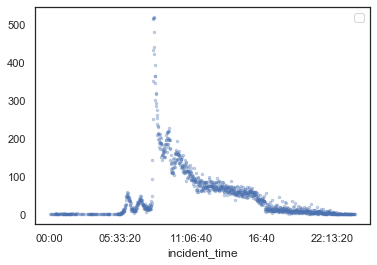

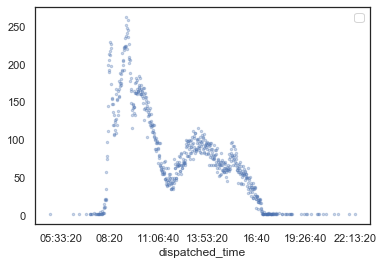

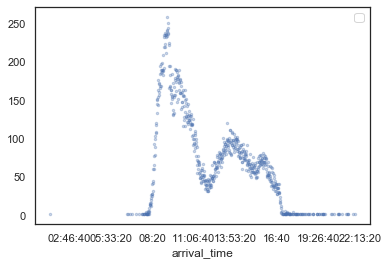

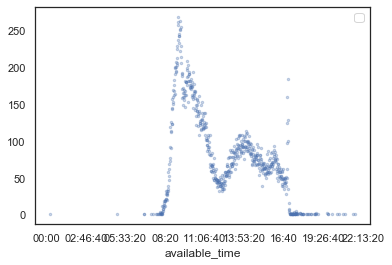

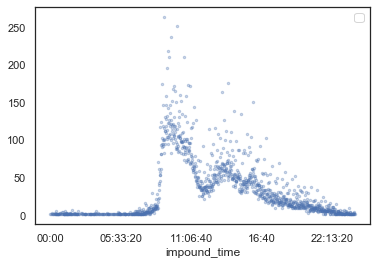

In [98]:
for col in time_cols:
    plot_dtcount(df, col, overlap = False, labels = time_cols)

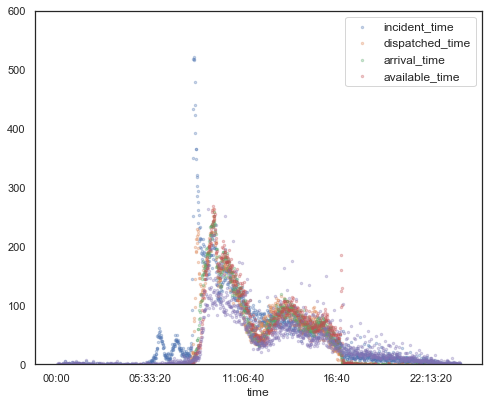

In [99]:
# plotting frequency of each time feature:
f, ax = plt.subplots(figsize=(8, 6.5))
for col in time_cols:
    plot_dtcount(df, col
                 , (0, 600)
                 , labels = time_cols)

Around 9am-ish the incident count reaches a peak, then once again rises between 12pm-4pm, Not seeing anything that would seem out of the ordinary here.

#### dates

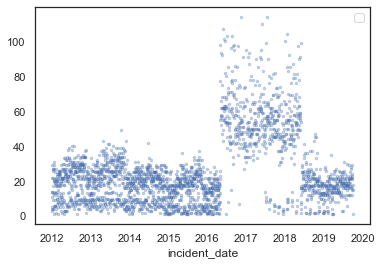

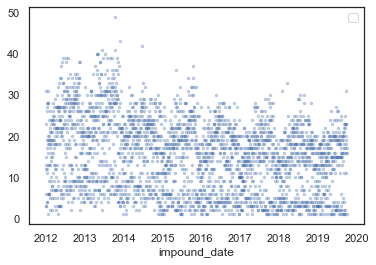

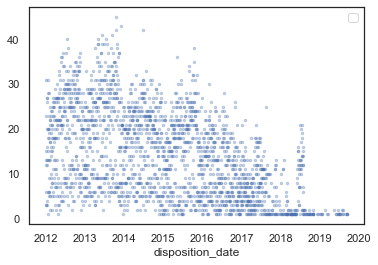

In [100]:
for col in date_cols:
    plot_dtcount(df, col, overlap = False, labels = date_cols)

Why does the disposition date and slightly with impound date decline in incidents?
It's possible that measures have been taken over time to reduce the amount of impounds, but with the disposition date, I'm wondering if the animal control facility just hasn't been consistently filling out that part of the record in the past couple of years.

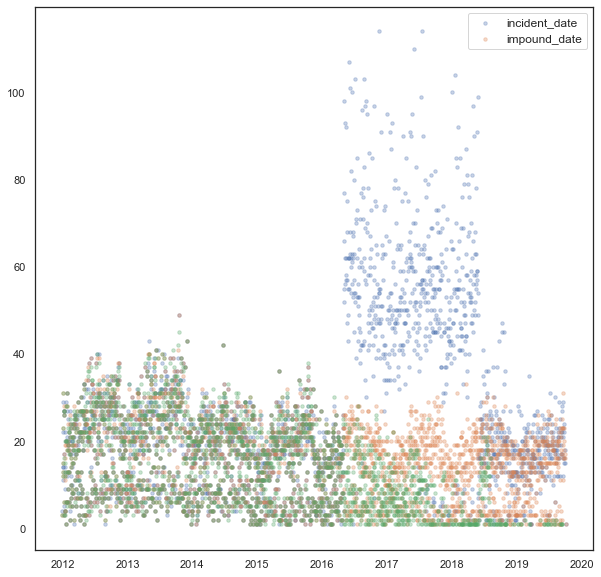

In [101]:
f, ax = plt.subplots(figsize=(10, 10))
for col in date_cols:
    plot_dtcount(df, col, overlap = True, labels = date_cols, alpha=.3, size=12)

I would have expected the disposition date, incident date, and impound date, to have a more positive, collinear relationship throughout the full 8 years of the data, it's strange that after 2016, there's much more irregularities.  The frequency of incident date is so elevated between 2016-1018. It reaches 100 counts some days, but rarely over 40 on the surrounding times. Is this an issue of data management or is there some other reason for this? I'm questioning the reliability of the the date data.

#### trends

##### bite incidents

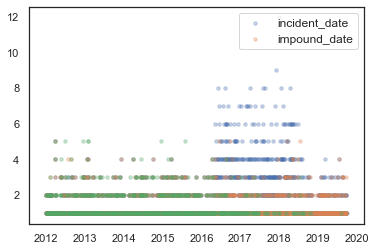

In [102]:
bite_df = df[df['service_type']=='bite_dangerous']

#f, ax = plt.subplots(figsize=(10, 10))
for col in date_cols:
    plot_dtcount(bite_df, col, overlap = True, labels = date_cols, alpha=.3, size=12)

###### __Ignore below__.
___
After trying to look for trends in various conditions, I've given up on using the dates or times to do so. I can't figure out why the dates data is so irregular.  The time data appears normal, but the conditions I looked into were all consistent with the incident counts like you would expect.

In [103]:
euth_df = df[df['disposition']=='euthanized']

friendly_df = df[df['temperment']=='dangerous']

returned_df = df[df['disposition']=='return_to_owner']

dog_df = df[df['species']=='dog']

cruelty_df = df[df['disposition']=='cruelty_case']

# f, ax = plt.subplots(figsize=(10, 10))
# for col in date_cols:
#     plot_dtcount(returned_df, col, overlap = True, labels = date_cols, alpha=.3, size=12)   
# # plot_dtcount(df5, 'incident_date', overlap = False, labels = time_cols)

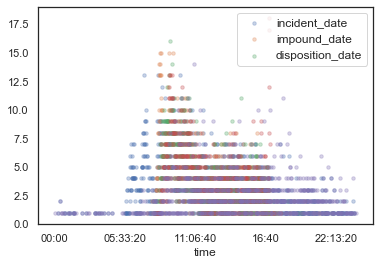

In [104]:
for col in time_cols:
    plot_dtcount(bite_df, col, overlap = True, labels = time_cols, alpha=.3, size=12)   
# plot_dtcount(df5, 'incident_date', overlap = False, labels = time_cols)

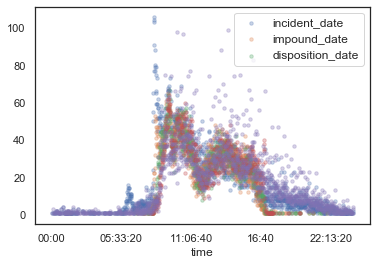

In [105]:
for col in time_cols:
    plot_dtcount(dog_df, col, overlap = True, labels = date_cols, alpha=.3, size=12)  

How do the service types from 2016 on compare to those before 2016

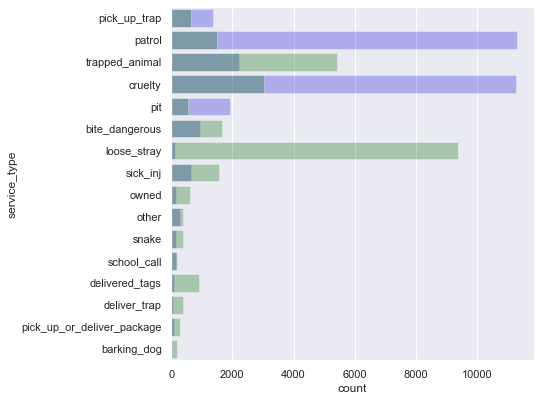

In [20]:
df_pre = df.loc[df['inc_dt'] < '2016-08-12 00:00:00 ']
df_post = df.loc[df['inc_dt']> '2016-08-12 00:00:00']
f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.countplot(y='service_type', data=df_pre, color='blue', alpha=.3)
sns.countplot(y='service_type', data=df_post, color='green', alpha=.3);

The first 1/2 incidents are more often patrol and cruelty, and the second half of data is heavier on loose/stray, trapped, and sick/injured.

In [21]:
len(df_pre.isna())
len(df_post.isna())

31664

31869

### * animal features -*  UNFINISHED

#### condition, disposition, size, species, temperment

In [106]:
#value counts of species, size, condition, and temperment features
ssct_df = df[['species', 'size', 'condition', 'temperment', 'disposition']]

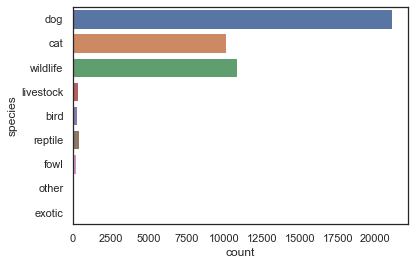

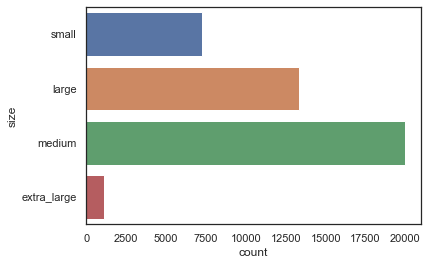

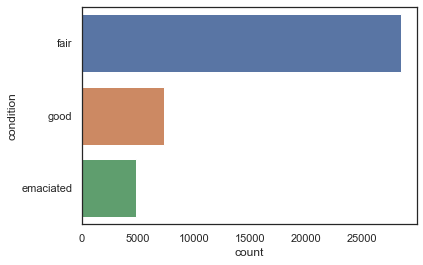

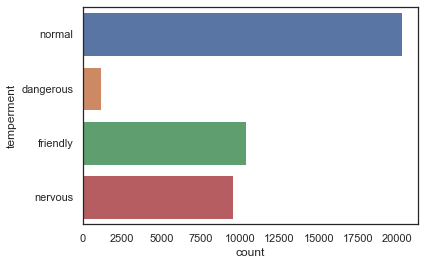

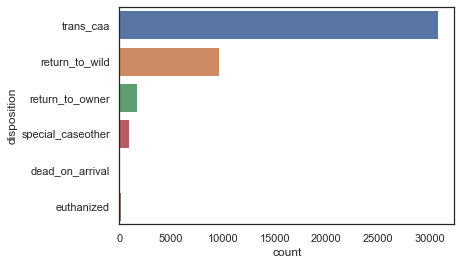

In [107]:
plot_counts(ssct_df)

#### correlations

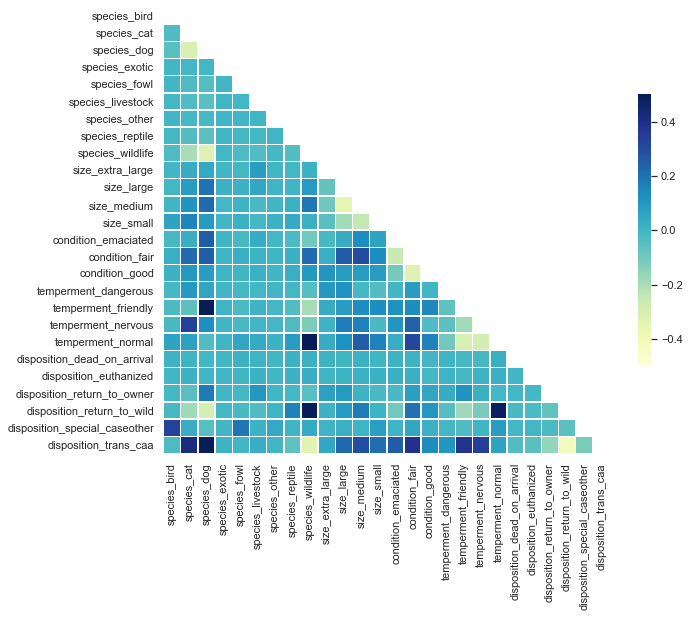

In [108]:
# correlations between species, size, condition, and temperment
corr_plot(ssct_df, minv=-.5, maxv=.5)

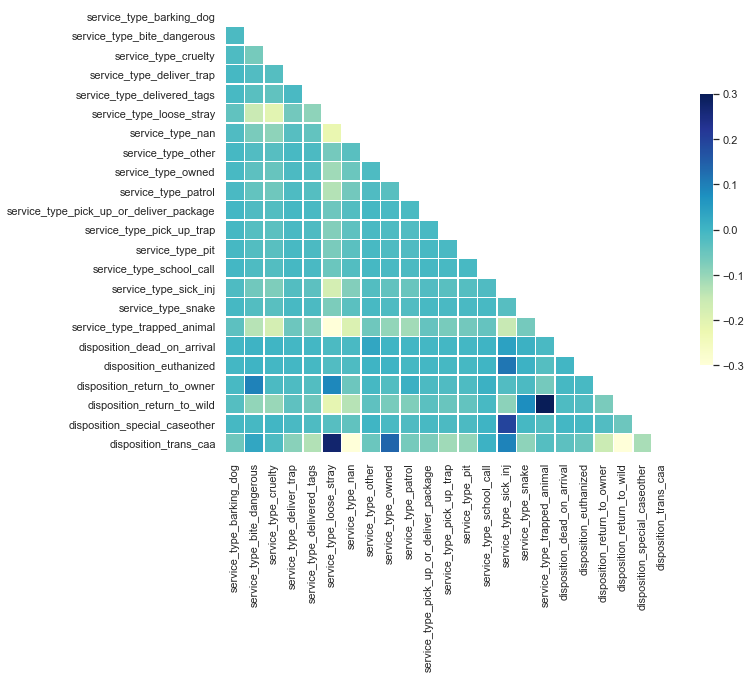

In [109]:
df3 = df[['service_type', 'disposition']]
corr_plot(df3)
# for word in ('loose_stray', 'sick_inj', 'owned', 'trapped_animal', 'patrol', 'school_call'
#             ,'other', 'pit', 'snake', 'pick_up_trap'):
#     df3['service_type'] = df3['service_type'].replace(word, 'not_bite/dang')

____